In [1]:
import numpy as np
import pandas as pd
import torch
import random
from tqdm import tqdm
from sklearn.metrics import f1_score
from os import path
from os import listdir
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from math import log2, e
from collections import deque
from copy import deepcopy
from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D

In [2]:
data = pd.read_csv('dataset_191_wine.csv')

In [3]:
X = np.array(data.drop('class', axis=1))
Y = np.array(data['class'])
X.mean(axis=0)

array([1.30006180e+01, 2.33634831e+00, 2.36651685e+00, 1.94949438e+01,
       9.97415730e+01, 2.29511236e+00, 2.02926966e+00, 3.61853933e-01,
       1.59089888e+00, 5.05808988e+00, 9.57449438e-01, 2.61168539e+00,
       7.46893258e+02])

In [4]:
X = (X - X.mean(axis=0)) / X.std(axis=0)
n = X.shape[0]
features = X.shape[1]
dist = [0] * n
for i in range(n):
    dist[i] = [0] * n
    for j in range(n):
        dist[i][j] = np.linalg.norm(X[i] - X[j])
dist

[[0.0,
  3.497535222046172,
  3.0266079435741324,
  2.8425046545212034,
  3.5668538927030355,
  2.5252898798163663,
  2.5532316096221193,
  2.407783878217233,
  2.9643489076463805,
  2.548898211510675,
  2.772406322635215,
  3.4098677046974117,
  3.3713291668485166,
  3.8851252204845186,
  3.447944598956778,
  3.0711882381079985,
  2.7202226380207475,
  3.051494896233691,
  3.5599087128795732,
  2.499925252041913,
  1.2878931632008224,
  3.640688841948945,
  2.4301588272199326,
  3.490053443414243,
  3.2896954483415897,
  4.9088401461733495,
  3.3559352336972936,
  3.9437209901701578,
  2.940049965133481,
  2.602765680743312,
  3.610074346115375,
  3.026924575213031,
  3.0051205540565586,
  3.4189542229852155,
  3.0188692983743137,
  2.815686587361931,
  3.3734415286718504,
  3.7936223822897577,
  3.87271646658024,
  2.6809202981921048,
  1.8798772047972643,
  4.299768820170305,
  2.704624115947255,
  3.8831765271341565,
  2.7535473537367934,
  3.380186008170782,
  2.7221346119406276,


In [5]:
e_array = [x / 10 for x in range(80)]
minPoints_array = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [6]:
def dfs(now, e, minPoints, c):
    ans = 0
    for i in range(n):
        if (dist[now][i] <= e):
            ans += 1
    if (ans > minPoints):
        color[now] = c
        for i in range(n):
            if (dist[now][i] <= e):
                if (color[i] == 0):
                    dfs(i, e, minPoints, c)
            if (noise[i] == 1):
                noise[i] = 0
                color[now] = c
                ifgran[i] = 1
    else:
        if (ifgran[now] == 0):
            noise[now] = 1

In [7]:
mas = [0] * len(e_array)
rad = [0] * len(e_array)
CH = [0] * len(e_array)
index = 0
Y_found = []
for e in tqdm(e_array):
    for minPoints in minPoints_array:
        used = [0] * n
        color = [0] * n
        c = 1
        ifgran = [0] * n
        noise = [0] * n
        for i in range(n):
            if (color[i] == 0):
                dfs(i, e, minPoints, c)
                c += 1
            #print(np.unique(color), len(np.unique(color)))
        tp = 0
        fn = 0
        tnfp = 0
        for i in range(n):
            for j in range(n):
                if (color[i] != 0 and color[j] != 0):
                    if (color[i] == color[j]):
                        if (Y[i] == Y[j]):
                            tp += 1
                        else:
                            tnfp += 1
                    else:
                        if (Y[i] == Y[j]):
                            tnfp += 1
                        else:
                            fn += 1
                else:
                    if (Y[i] == Y[j]):
                        tnfp += 1
                    else:
                        fn += 1
        if (index == 24):
            if (rad[index] < (tp) / (tp + tnfp)):
                Y_found = deepcopy(color)
        mas[index] = max(mas[index], (tp + fn) / (tp + fn + tnfp))
        rad[index] = max(rad[index], (tp) / (tp + tnfp))
        if (len(np.unique(color)) > 1):
            dsfds = (n - len(np.unique(color))) / (len(np.unique(color)) - 1)
            to_sum_up = 0
            to_sum_down = 0
            cluster = [0] * c
            amount = [0] * c
            for i in range(c):
                cluster[i] = np.zeros(features)
            for i in range(n):
                if (color[i] != 0):
                    cluster[color[i]] += X[i]
                    amount[color[i]] += 1
            for i in range(c):
                if (amount[i] > 0):
                    to_sum_up += amount[i] * np.linalg.norm(cluster[i] / amount[i] - X.mean(axis=0))
            for i in range(n):
                if (color[i] != 0):
                    to_sum_down += np.linalg.norm(X[i] - cluster[color[i]] / amount[color[i]])
            if (to_sum_down > 0):
                CH[index] = max(CH[index], dsfds * to_sum_up / to_sum_down)
    index += 1

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [01:35<00:00,  1.19s/it]


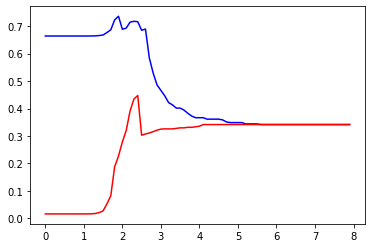

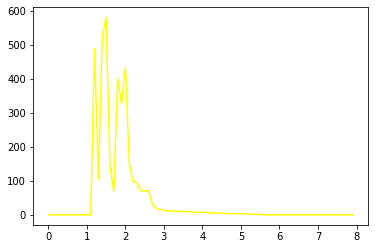

In [8]:
plt.plot(e_array, mas, linestyle='solid', color='blue', label="normal")
plt.plot(e_array, rad, linestyle='solid', color='red', label="normal")
plt.show()
plt.plot(e_array, CH, linestyle='solid', color='Yellow', label="normal")

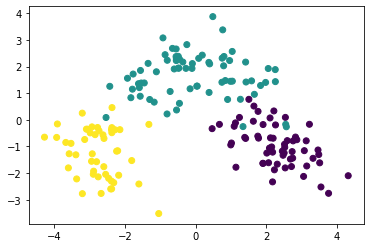

In [11]:
_, axis = plt.subplots()
X = PCA(n_components = 2).fit_transform(X)
axis.scatter(X[:,0], X[:,1], c = Y)

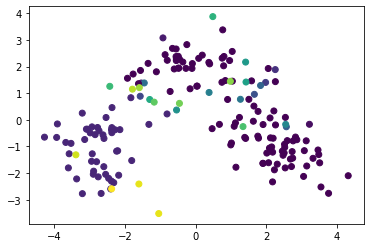

In [12]:
plt.scatter(X[:,0], X[:,1], c = Y_found)

In [13]:
np.unique(Y_found)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])